## Проект 5. Компьютер говорит «Нет»

## 1. Импорт библиотек

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

## 2. Импорт данных

In [2]:
train = pd.read_csv("./train.csv")

In [ ]:
'''
Описания полей датасета

client_id - идентификатор клиента
education - уровень образования
sex - пол заемщика
age - возраст заемщика
car - флаг наличия автомобиля
car_type - флаг автомобиля иномарки
decline_app_cnt - количество отказанных прошлых заявок
good_work - флаг наличия “хорошей” работы
bki_request_cnt - количество запросов в БКИ
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса
income - доход заемщика
foreign_passport - наличие загранпаспорта
default - наличие дефолта
'''

## 3. Предварительный анализ данных

In [6]:
pandas_profiling.ProfileReport(train) 

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Анализ по переменным

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [15]:
# Как мы видим, пропуски встречаются только в информации об образовании клиентов. 

# Отсутсвие образования может быть важным фактором, создаем бинарную переменную
train['education_nan'] = pd.isna(train['education']).astype('uint8')

# Заполняем образование самым распространеным школьным 'SCH'
train['education'] = train['education'].fillna('SCH')

# TODO - найти образование через обучение модели

In [18]:
# Полученные признаки сгруппируем в три категории по типу их обработки 
# (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

# бинарные переменные
bool_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_nan']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income','bki_request_cnt']

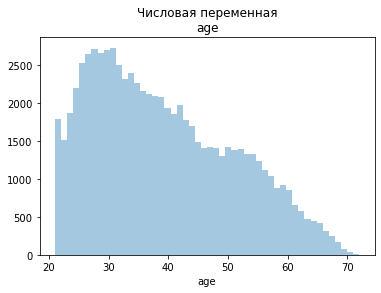

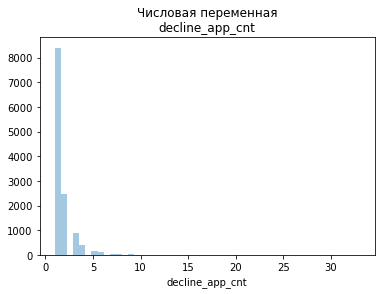

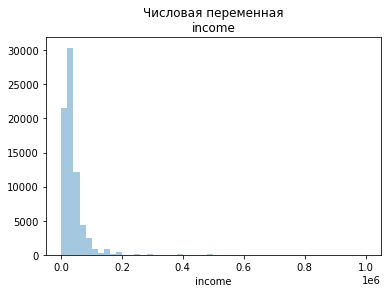

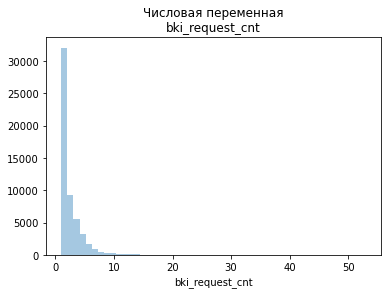

In [20]:
# Посмотрим распределение числовых данных:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title('Числовая переменная\n' + i)
    plt.show()

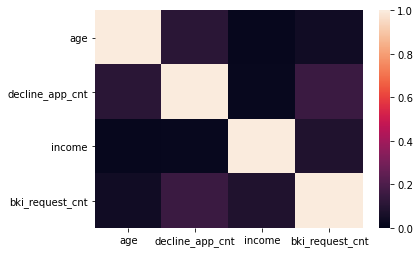

In [22]:
# Оценим корреляцию Пирсона для непрерывных переменных:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1)

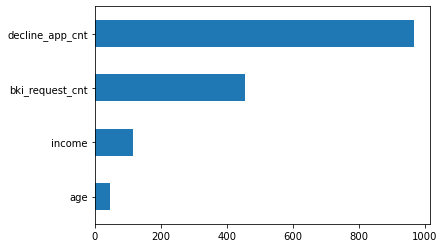

In [23]:
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

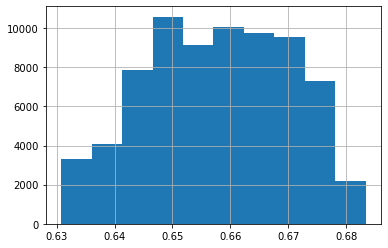

In [29]:
# логарифмируем возвраст
train['age'] = np.log(train['age'] + 1)
# строим график после логарифмирования
train['age'].hist()

In [30]:
# логарифмируем количество отказов прошлых заявок
